# Connor Rice's Data Analysis of MGH_Olink_COVID_Apr_27_2021
Thank you for your consideration and giving me the opportunity to show how I can be a valuable member of the Ha Lab. I am going to try to write as much of my thought process down while I go through this data. I want this Jupyter Notebook to represent how I go about analyzing a new dataset. That way, the Novelna team can get a better understanding of how I think about and approach challenging problems.

This whole Notebook is going to be raw. I am trying to keep my thoughts in order and show the evolution of me understanding these datasets. It will go from top to bottom from where I started and where I ended. That is the big reason why I decided to use Notebooks over a different Python IDE for this little project.

The first thing that I am going to do is to get to know the datasets. My main goal is just to see what’s in the datasets and get an understanding of how to work with it. I am going to do them independently, then try to do them together. When I do them together, I am also going to construct the training and testing data for a feature/protein extraction then into a classification algorithm. I am wanting to construct a classification algorithm that uses x amount of proteins of the most importance since that is what Mehrdad has been talking to me about.

I believe the logic for approaching the problem this way is so that we can validate whether or not the protein selection was a good selection. From what I know about biological processes, it’s almost never just one protein that turns on or off a pathway, but rather a conglomerate of proteins in certain concentration that dictate how the biological processes work. The feature extraction would give us the conglomerate of proteins that could be indicative of certain biological processes being present.

## Getting to Know the Datasets
In this section, I am going to use pandas to get to know the datasets. Please note that I use patient and subject_id interchangeably.

In [1]:
import pandas as pd

### Clinical Information Dataset
Going through the variable description  of the clinical information dataset tells me a few things right off the bat. The data can be split up into a few main ideas: covid, pre-existing diseases, current symptoms, and on days $\{0,3,7\}$ their acuity score and proteins concentration(?) categories. There are a few variables (DE_draw, acuity_28, and Trop_72) that aren't directly in one of those main ideas, but that is because I don't think I will be using them to figure out the extraction of proteins and constructing a classification algorithm.

I like splitting up thinking about the data this way for a few reasons, it helps tell me a story of what the data can tell. Here is where I can figure out what patient has covid and doesn't. It lists of the pre-existing diseases so it can help me group the other dataset nicely along with their symptoms, if needed. The 3 different draws for D0 on day 0, D3 between day 2 and 4, and D7 between day 5 and 9 tells me how the study was done. My first reaction is that there is a few things that we could do with this information, we could try to do some sort of time series, where we predict protein levels to show how covid progresses. That would be something that could be worthwhile exploring.

What I am going to work towards first is use D0_draw to figure out the extraction of proteins to run a classification algorithm to see if someone has covid or not. I know that this is only using a subset of the data, but I want to see if I can get the algorithm to work first before going more complicated.

Before doing that, I want to see what is in the clinical information dataset, i.e. the basic statistics of this dataset. 

In [2]:
clinical_data = pd.read_csv("MGH_COVID_Clinical_Info.txt", delimiter=";")
print(clinical_data)

     subject_id  COVID  Age_cat  BMI_cat  HEART  LUNG  KIDNEY  DIABETES  HTN  \
0             1      1        1        4      0     0       0         0    0   
1             2      1        2        2      0     0       0         0    0   
2             3      1        3        4      0     1       0         0    0   
3             4      1        1        2      0     0       0         0    0   
4             5      1        3        3      0     0       0         1    1   
..          ...    ...      ...      ...    ...   ...     ...       ...  ...   
379         382      1        1        3      0     0       0         0    0   
380         383      1        5        1      0     0       1         1    1   
381         384      1        5        2      1     0       0         0    1   
382         385      1        3        3      0     0       0         0    0   
383         386      0        4        3      0     1       0         0    1   

     IMMUNO  ...  crp_3_cat  ddimer_3_c

The first thing that I notice is that there is 384 rows, yet the 'subject_id' ranges from 1 to 386. 

In [3]:
all_ids = set(range(1,387))
clinical_ids = set(clinical_data['subject_id'].unique())
print(f"Missing Ids: {all_ids-clinical_ids}")

Missing Ids: {269, 183}


I wonder why subject_id $\{ 269, 183\}$ are missing. I am debating if I should relabel the data so it is from [1,384] rather than [1,386] where two values are missing. I will wait to do that until after I look at the Olink NPX dataset, since that dataset might tell more of a story of what is happening with those missing samples.

What I am going to do now is create a few bar charts counting each binary column just to see what is in the data. The charts that I am going to make is going to use the matplotlib library.

In [4]:
import matplotlib.pyplot as plt

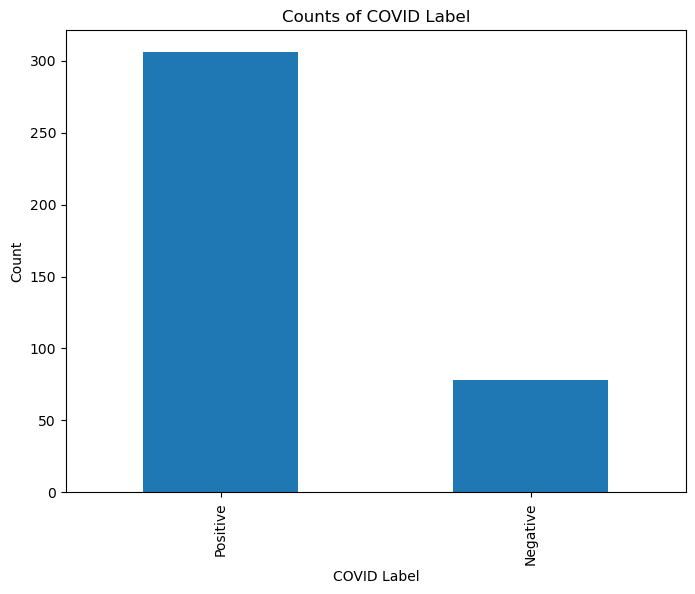

Percent of subject_ids that tested postive for covid: 0.796875%
Percent of subject_ids that tested negative for covid: 0.203125%


In [5]:
covid_counts = clinical_data['COVID'].value_counts()
covid_counts.plot(kind='bar', figsize=(8, 6))
plt.xticks(ticks=[0, 1], labels=['Positive', 'Negative'])
plt.title('Counts of COVID Label')
plt.xlabel('COVID Label')
plt.ylabel('Count')
plt.show()

percent_pos = covid_counts[1] / len(clinical_data['subject_id'])
percent_neg = covid_counts[0] / len(clinical_data['subject_id'])

print(f"Percent of subject_ids that tested postive for covid: {percent_pos}%")
print(f"Percent of subject_ids that tested negative for covid: {percent_neg}%")

That is nice to see that the data is roughly 80% covid positive and 20% covid negative. That means if I do a time series analysis, I'll be able to measure what would be expected throughout the draws with the tested covid negative group. 

That being said, my current direction I think I am heading is using the D0_draw to predict what selection of proteins would be good for a diagnosis classification model. I think I would prefer to see where I am headed to with 50% positive and 50% negative. The reason why I would want it 50/50 is because it would be more balanced with less bias towards positive or negative. This would directly translate into being able to make the model more generalizable to unseen data. However, I don't necessarily think that having it 80% positive and 20% negative is a bad thing; there just might be a bias towards the positive class.

The next few bar charts that I am going to construct are going to be grouped by the Covid class there 1 denotes positive and 0 denotes negative. I am wanting to make these bar charts grouped by the covid class because I want to see what portion of the categories are postive with covid and negative with covid.

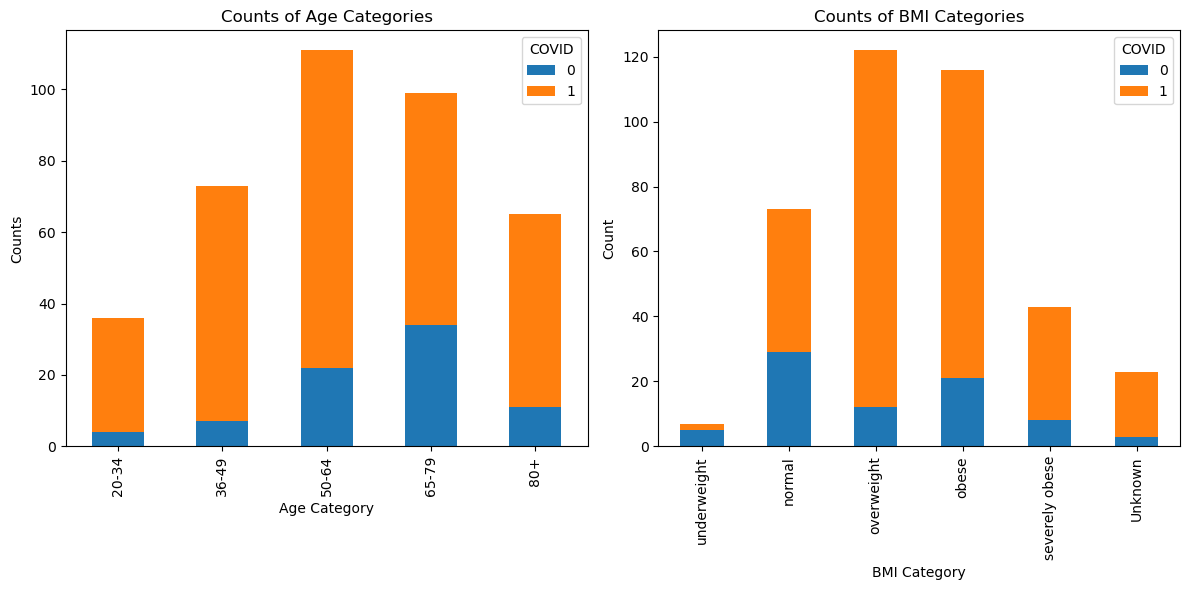

88.89% of subjects_ids between 20-34 are Covid Positive
90.41% of subjects_ids between 36-49 are Covid Positive
80.18% of subjects_ids between 50-64 are Covid Positive
65.66% of subjects_ids between 65-79 are Covid Positive
83.08% of subjects_ids between 80+ are Covid Positive

28.57% of subjects_ids that are underweight are Covid Positive
60.27% of subjects_ids that are normal are Covid Positive
90.16% of subjects_ids that are overweight are Covid Positive
81.90% of subjects_ids that are obese are Covid Positive
81.40% of subjects_ids that are severely obese are Covid Positive
86.96% of subjects_ids that are Unknown are Covid Positive


In [6]:
age_covid_counts = clinical_data.groupby(['Age_cat', 'COVID']).size().unstack()
bmi_covid_counts = clinical_data.groupby(['BMI_cat', 'COVID']).size().unstack()

age_cat = ['20-34', '36-49', '50-64', '65-79', '80+']
bmi_cat = ['underweight', 'normal', 'overweight', 'obese', 'severely obese', 'Unknown']

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

age_covid_counts.plot(kind = 'bar', stacked = True, ax = axes[0])
axes[0].set_title('Counts of Age Categories')
axes[0].set_xlabel('Age Category')
axes[0].set_xticks(ticks=[0, 1, 2, 3, 4])
axes[0].set_xticklabels(age_cat)
axes[0].set_ylabel('Counts')

bmi_covid_counts.plot(kind = 'bar', stacked = True, ax = axes[1])
axes[1].set_title('Counts of BMI Categories')
axes[1].set_xlabel('BMI Category')
axes[1].set_xticks(ticks=[0, 1, 2, 3, 4, 5])
axes[1].set_xticklabels(bmi_cat)
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

tot_age = age_covid_counts.sum(axis = 1)
age_percent_positive = age_covid_counts[1] / tot_age

for i in range(len(age_percent_positive)):
    print(f"{age_percent_positive.iloc[i]*100:.2f}% of subjects_ids between {age_cat[i]} are Covid Positive")

print( )
    
tot_bmi = bmi_covid_counts.sum(axis = 1)
bmi_percent_positive = bmi_covid_counts[1] / tot_bmi

for i in range(len(bmi_percent_positive)):
    print(f"{bmi_percent_positive.iloc[i]*100:.2f}% of subjects_ids that are {bmi_cat[i]} are Covid Positive")

I did the age and BMI categories separate from the rest because these categories had more than a binary classification. This is mostly for me to see what is in our data and what our data can represent. With a basic bar chart, it's easy to see that more than half of our data is over the age of 50 and the majority of them are overweight or obese. The amount of underweight subject_ids seems significantly lower than all other BMI. The amount of unknown BMI can be treated as missing data, but in context of what I am trying to do I don't think it really matters. Doing bootstrapping techniques would be able to give me quantifiable means and variance, which in turn would be able to show how our data is distributed. 

The reason that I think it is important to understand how our data spreads is to be able to see how our data is biased and how it can be generalized. Based off the low amount of underweight individuals and being at 28.57% positive for Covid, it is going to be harder to get a model to represent this BMI category because in all other BMI categories there are significantly more samples and one BMI category has above 60% covid positive, the rest above 80%. This just gives me the thought that a model could underperform for underweight BMI subjects. For the age categories, it follows the percentages of the rest of the data fairly well so I am not concerned in using it.

With that being said, I am assuming that Covid proteins in the blood stream doesn't get affected too much about different age or BMI categories. That way when I go into feature/protein selection, I can use all of the D0_draw data rather than a partition of it.

82.43% of subjects_ids that does not have pre-existing HEART disease are Covid Positive
67.61% of subjects_ids that does have pre-existing HEART disease are Covid Positive

86.33% of subjects_ids that does not have pre-existing LUNG disease are Covid Positive
62.26% of subjects_ids that does have pre-existing LUNG disease are Covid Positive

82.04% of subjects_ids that does not have pre-existing KIDNEY disease are Covid Positive
67.21% of subjects_ids that does have pre-existing KIDNEY disease are Covid Positive

79.59% of subjects_ids that does not have pre-existing DIABETES disease are Covid Positive
79.86% of subjects_ids that does have pre-existing DIABETES disease are Covid Positive

86.49% of subjects_ids that does not have pre-existing HTN disease are Covid Positive
73.37% of subjects_ids that does have pre-existing HTN disease are Covid Positive

82.16% of subjects_ids that does not have pre-existing IMMUNO disease are Covid Positive
59.52% of subjects_ids that does have pre-ex

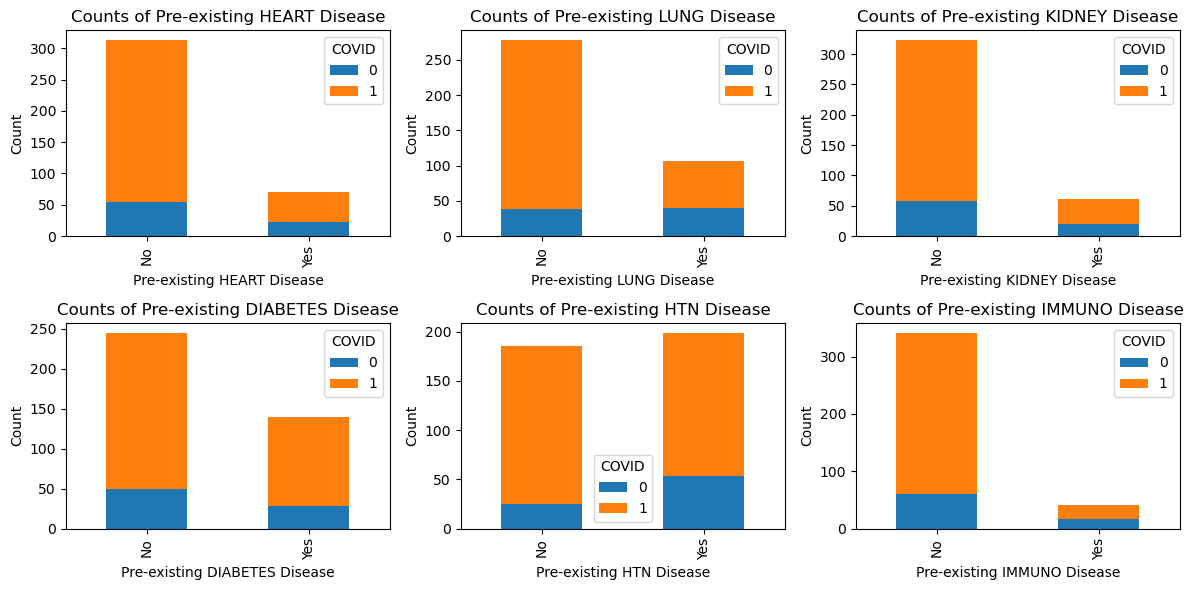

In [7]:
pre_disease = ['HEART', 'LUNG', 'KIDNEY', 'DIABETES', 'HTN', 'IMMUNO']
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

Y_N = ['does not', 'does']

for i, ax in enumerate(axes.flatten()):
    pre_disease_covid_count = clinical_data.groupby([pre_disease[i], 'COVID']).size().unstack()
    pre_disease_covid_count.plot(kind = 'bar', stacked = True, ax = ax)
    ax.set_title(f'Counts of Pre-existing {pre_disease[i]} Disease')
    ax.set_xlabel(f'Pre-existing {pre_disease[i]} Disease')
    ax.set_xticks(ticks = [0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_ylabel('Count')
    
    tot_pre_disease_count = pre_disease_covid_count.sum(axis = 1)
    percentage_positive = pre_disease_covid_count[1] / tot_pre_disease_count
    
    for j in range(2):
        print(f"{percentage_positive.iloc[j]*100:.2f}% of subjects_ids that {Y_N[j]} have pre-existing {pre_disease[i]} disease are Covid Positive")
    print()    

plt.tight_layout()
plt.show()

The first thing that I notice is that there are more patients who have hypertension than patients that don’t. On top of that, there are more hypertension cases proportionally than any other pre-existing diseases. Pretty much all categories follow the 80% COVID positive and 20% COVID negative distribution. It is nice to see that, so we know that our data is relatively evenly spread. It just helps for generalizability.

55.56% of subjects_ids that does not have Resp_Symp are Covid Positive
80.87% of subjects_ids that does have Resp_Symp are Covid Positive

66.42% of subjects_ids that does not have Fever_Sympt are Covid Positive
87.04% of subjects_ids that does have Fever_Sympt are Covid Positive

75.56% of subjects_ids that does not have GI_Symp are Covid Positive
85.53% of subjects_ids that does have GI_Symp are Covid Positive



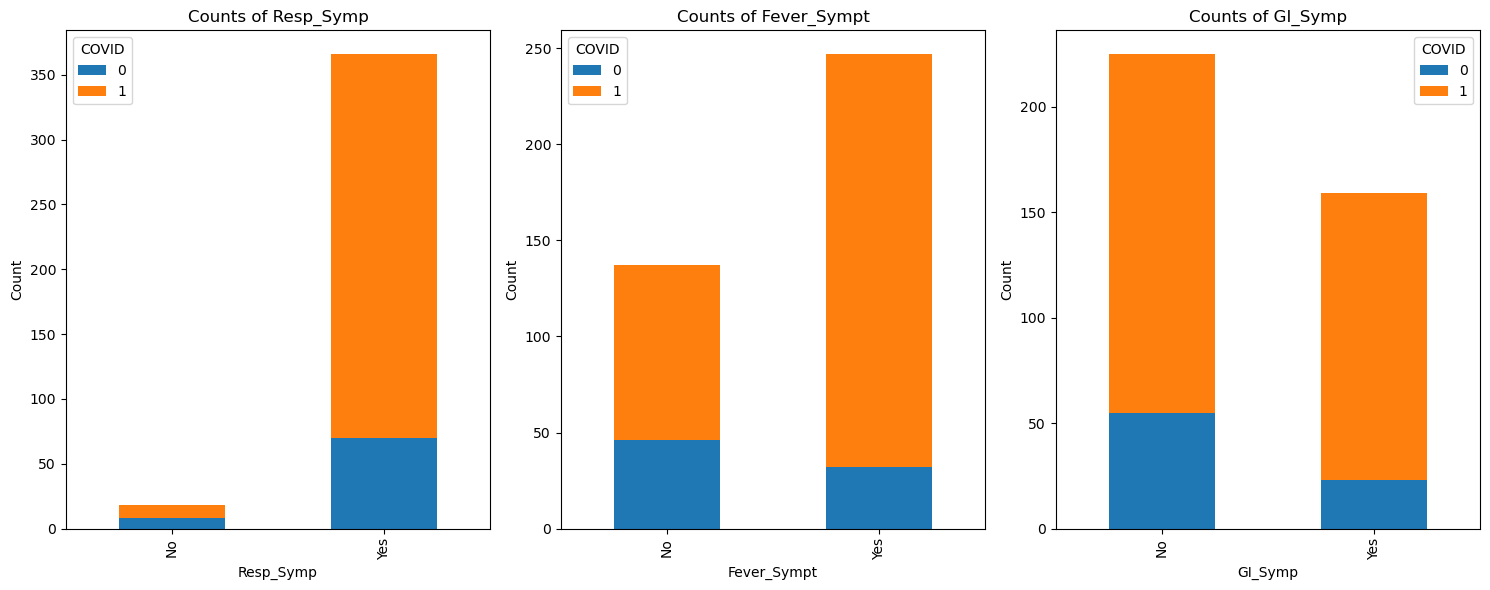

In [8]:
symptoms = ['Resp_Symp', 'Fever_Sympt', 'GI_Symp']
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 6))

Y_N = ['does not', 'does']

for i, ax in enumerate(axes.flatten()):
    symptoms_covid_count = clinical_data.groupby([symptoms[i], 'COVID']).size().unstack()
    symptoms_covid_count.plot(kind = 'bar', stacked = True, ax = ax)
    ax.set_title(f'Counts of {symptoms[i]}')
    ax.set_xlabel(f'{symptoms[i]}')
    ax.set_xticks(ticks = [0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_ylabel('Count')
    
    tot_symptoms_count = symptoms_covid_count.sum(axis = 1)
    percentage_positive = symptoms_covid_count[1] / tot_symptoms_count
    
    for j in range(2):
        print(f"{percentage_positive.iloc[j]*100:.2f}% of subjects_ids that {Y_N[j]} have {symptoms[i]} are Covid Positive")
    print()

plt.tight_layout()
plt.show()

It would make sense that pretty much all of the subjects have resp_symp. I am assuming these datasets came from a hospital, and it would make sense that a lot of people are in the hospital for resp_symp. I could just be inherently wrong on that, but I am going to roll with it. It follows the rest of the data, besides underweight BMI, that there are more COVID positive subject_ids in each category than COVID negative subject_ids. It does add onto the idea that the classification model would have a bias towards COVID.

However, I feel like that leads into a short discussion. Since I am wanting to construct a classification model to predict if someone has COVID or not based off of protein selection, would it be a bad thing to have a bias towards the COVID positive classification? If the tool is meant to accurately identify instances of a particular class, then bias towards that class could potentially be beneficial, as long as it doesn’t compromise the overall performance or fairness of the tool. It might be acceptable to have a bias towards that disease class in order to ensure that affected individuals are correctly identified, even if it means having more false positives in other classes. That being said, no one would want to hear that they have COVID, or another disease, when they are a false positive.

The next part of the data that I am going to look at are the study draw and acuity scores. This part here is going to tell me how this study progressed, i.e., what patients did what part of the study and their overall wellbeing. This part will also help out with constructing the datasets that I would be using to train and test for the feature/protein extraction and classification algorithm.

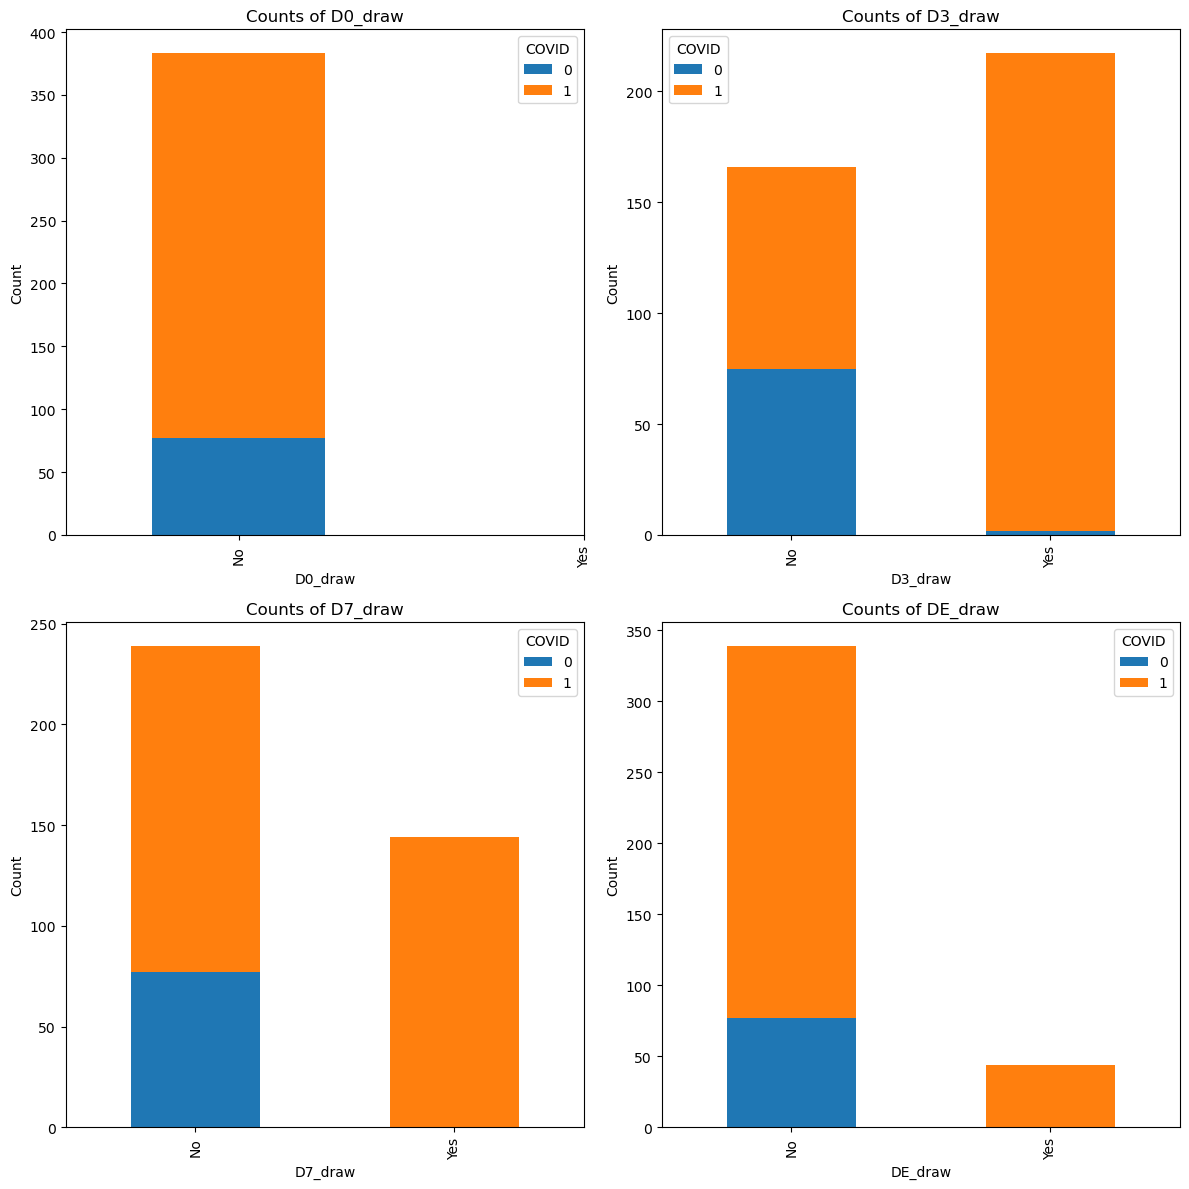

In [9]:
draw = ['D0_draw', 'D3_draw', 'D7_draw', 'DE_draw']
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))

for i, ax in enumerate(axes.flatten()):
    draw_covid_count = clinical_data.groupby([draw[i], 'COVID']).size().unstack()
    draw_covid_count.plot(kind = 'bar', stacked = True, ax = ax)
    ax.set_title(f'Counts of {draw[i]}')
    ax.set_xlabel(f'{draw[i]}')
    ax.set_xticks(ticks = [0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Something doesn't seem right about the D0_draw graph, given that all of the samples are over "no" for the draw on day 0. I know for fact that is not right, so I am going to look into it more.

In [10]:
D0_count = clinical_data['D0_draw'].sum()
print(D0_count)
print()

D0_draw_covid_count = clinical_data.groupby(['D0_draw', 'COVID']).size().unstack()
print(D0_count - D0_draw_covid_count.sum(axis=1) == 0)
print()

D0_no = clinical_data[clinical_data['D0_draw'] == 1]
extra_rows = clinical_data[~clinical_data.index.isin(D0_no.index)]

print(extra_rows['subject_id'])
print()
print(extra_rows.loc[383, 'D0_draw'])

383.0

D0_draw
1.0    True
dtype: bool

383    386
Name: subject_id, dtype: int64

nan


Well, it seems to be that everyone in this study got a day 0 draw. That makes a lot of sense, but what I did notice is that there is one subject_id that does not have a label for a draw on day 0. I am almost confident that they were, since why else would they be in this study. I will double check that in the Olink RPX dataset when I finish up with this in. In the meantime, I will assume that subject_id 386 did have a draw on day 0.

In [11]:
index_386 = clinical_data.index[clinical_data['subject_id'] == 386]
clinical_data.loc[index_386, 'D0_draw'] = 1

D0_no = clinical_data[clinical_data['D0_draw'] == 1]
extra_rows = clinical_data[~clinical_data.index.isin(D0_no.index)]

print(extra_rows['subject_id'])

Series([], Name: subject_id, dtype: int64)


For the classification model that I am wanting to construct, I think I am going to choose to really only look at D0_draws. That gets 100% of our patients, which is the most amount of samples. When it goes to day 3, 7, and exit, all if not close to all are COVID positive patients. If by adding those, I believe that it would create a bias towards the classification and proteins being selected towards COVID positive and I don’t really want to introduce that currently.

I do think that using the draws on day 0, 3, and 7 would be good to use to see how COVID progresses. If I were doing that, I would want to construct a dataset that has only the subject_ids that got the draws on day 0, 3, and 7. There would be advantages and disadvantages for having that dataset be only COVID positive or a combination, but just of the given data it would surely have to be since the draw on day 7 is entirely COVID positive.

For the protein part of the clinical information dataset, I am not going to use it. When skimming through the .txt file, I could tell that there is missing data inside of there. These proteins might have a significant role in the underlying biological processes, but we have the Olink NPX dataset that has all of the proteins and I want to play around with those. I am still going to go over the acuity of the clinical information because I am genuinely curious and it could lead to valuable information when constructing my dataset to do some ML models on.

Importing Line2D because I need it to do the graph I want to make. Odd number of chart on an even grid, lets make the remainder a key.

In [12]:
from matplotlib.lines import Line2D

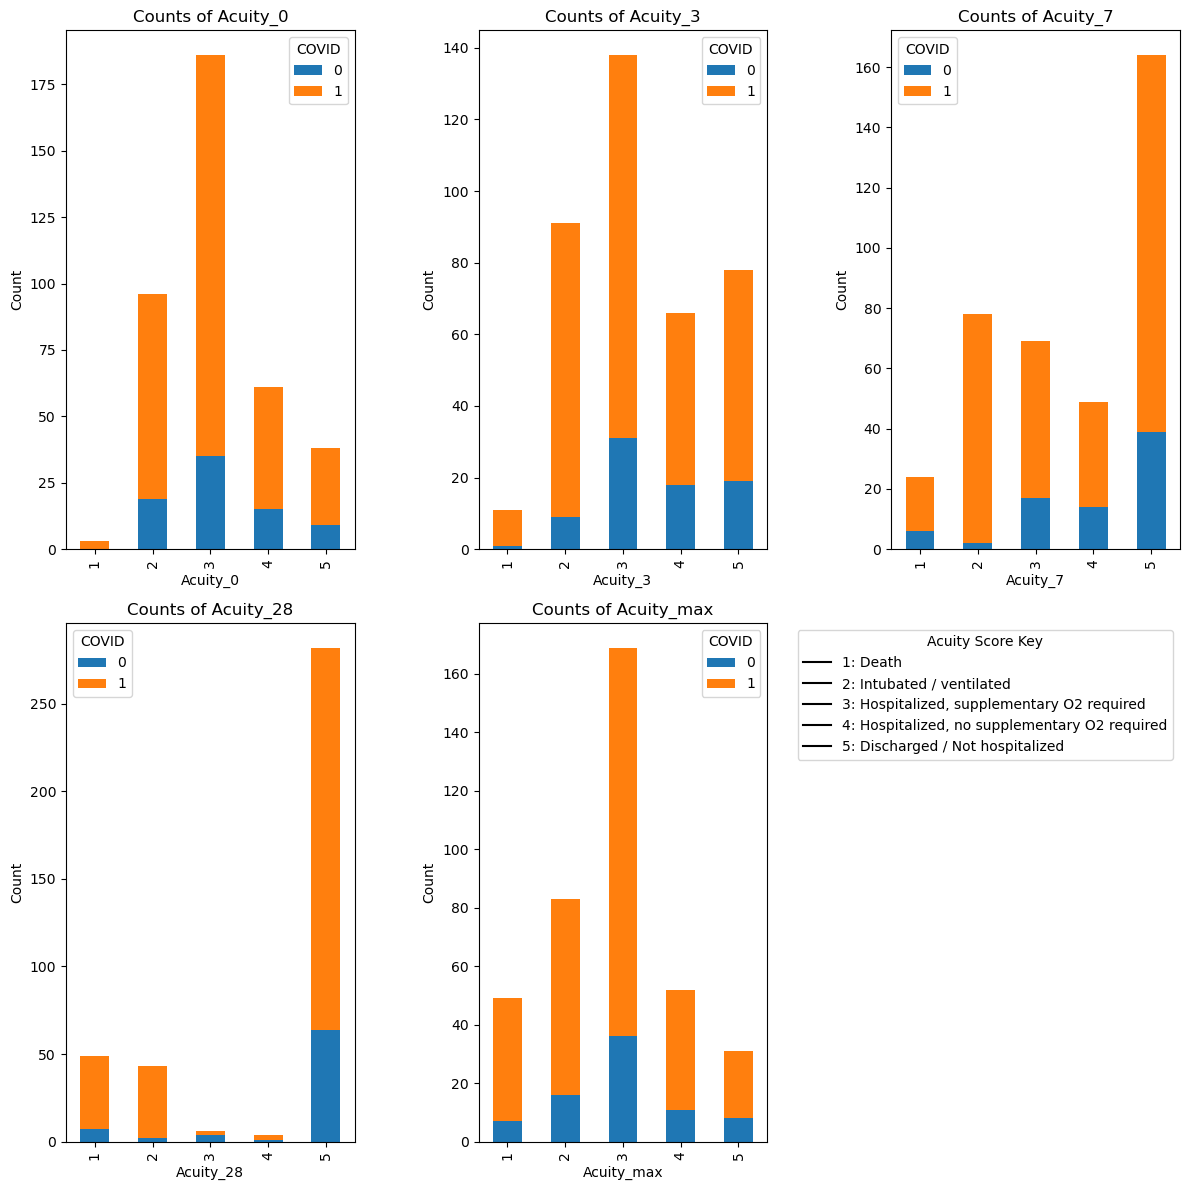

In [13]:
acuity = ['Acuity_0', 'Acuity_3', 'Acuity_7', 'Acuity_28', 'Acuity_max']
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 12))

acuity_key = ['1: Death', '2: Intubated / ventilated', '3: Hospitalized, supplementary O2 required',
                 '4: Hospitalized, no supplementary O2 required', '5: Discharged / Not hospitalized']
legend_handles = [Line2D([0], [0], linestyle='-', color='black', label=str(score)) for score in range(len(acuity_key))]
                     
for i, ax in enumerate(axes.flatten()):
    if i == 5:
        ax.axis('off')
        ax.legend(legend_handles, acuity_key, title='Acuity Score Key')
        continue 
    acuity_covid_count = clinical_data.groupby([acuity[i], 'COVID']).size().unstack()
    acuity_covid_count.plot(kind = 'bar', stacked = True, ax = ax)
    ax.set_title(f'Counts of {acuity[i]}')
    ax.set_xlabel(f'{acuity[i]}')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [14]:
day_0_dead = clinical_data[clinical_data['Acuity_0'] == 1]
print(day_0_dead['COVID'])
print("subject_id that died:", set(day_0_dead['subject_id']))

45     1
55     1
315    1
Name: COVID, dtype: int64
subject_id that died: {56, 318, 46}


I like how the trend from day 0 to day 28 shows that the majority recovered and went on their ways. Sadly, you can also see that the death count increased from day 0 to day 28. The other hospitalization treatments decreased. Three patients who had COVID passed away within the 24 hours of this study starting. I will need to double-check in the Olink NPX dataset that these patients’ data was collected just like all the others on day 0.

It is good that there is a range of hospitalization treatments captured within this data. If the study was looking at disease progression, it would be useful to use the acuity score to rank how the progression is manifesting towards overall health. But again, I am wanting to look at the day 0 data and use that to construct a classification model with the best proteins I can find.

### Olink NPX Dataset
This type of sequencing is new to me, so that is fun. I actually really like getting to know new types of analyses. Since this dataset is different from the clinical information dataset and a new type of dataset, I am going to approach getting to know this dataset differently. The first thing that I want to do is look at what the data actually is.

In the .txt file, scrolling all the way down, some of the SampleIDs are controls. This is going to be good to know and will need to be worked around when I construct my dataset for my classification model.

In [15]:
olink_data = pd.read_csv("MGH_COVID_OLINK_NPX.txt", delimiter=";")
print(olink_data)
print(olink_data.columns.tolist())

/var/folders/pw/0xzx218d3bd3znkygcp44dbc0000gn/T/ipykernel_56280/1636172754.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  olink_data = pd.read_csv("MGH_COVID_OLINK_NPX.txt", delimiter=";")


                          SampleID  subject_id Timepoint  Index   OlinkID  \
0                             1_D0         1.0        D0     56  OID21311   
1                             1_D0         1.0        D0     56  OID20921   
2                             1_D0         1.0        D0     56  OID21280   
3                             1_D0         1.0        D0     56  OID21269   
4                             1_D0         1.0        D0     56  OID20159   
...                            ...         ...       ...    ...       ...   
1271803  PLATE_CTRL_87010_B00202-3         NaN       NaN     60  OID20082   
1271804  PLATE_CTRL_87010_B00202-3         NaN       NaN     60  OID20082   
1271805  PLATE_CTRL_87010_B00202-3         NaN       NaN     60  OID20082   
1271806  PLATE_CTRL_87010_B00202-3         NaN       NaN     60  OID20082   
1271807  PLATE_CTRL_87010_B00202-3         NaN       NaN     60  OID20082   

        UniProt    Assay  MissingFreq            Panel Panel_Lot_Nr  \
0   

I don’t really care about the Index, OlinkID, Assay, Panel_lot_Nr, and PlateID columns in this dataset. These are useful when it comes to the sequencing, but given that the sequencing is already done, I have less of a need for them. The main idea that I want to do is a feature/protein extraction then use the best proteins to construct a classification model. As for the other column names, this is what I learned about them:

The subject_id is the same as on the clinical information dataset, along with the Timepoint referring to D0, D3, D7, and DE.

The UniProt is the database for proteins and this column has the protein code name there.

The MissingFreq indicates the proportion of samples in which data for a specific assay or protein is missing. This metric provides insight into the completeness of the dataset and the reliability of the protein measurements.

The Panel shows what type of protein categorization based on its relevance to a specific biological area or research focus.

The QC_Warning indicates issues or anomalies identified during the quality control process of the assay. These warnings alert researchers to potential issues with the data quality that may affect the reliability or interpretation of the results.

The Assay_Warning specifically relates to the performance of the assay itself. These warnings signal potential issues with the assay methodology, reagents, or protocols that could impact the accuracy or reproducibility of the results.

The Normalization is how they normalized the data.

The LOD is the limit of detection. LOD is calculated separately for each Olink assay and sample plate. The LOD is based on the background, estimated from negative controls included on every plate, plus three standard deviations. The standard deviation is assay specific and estimated during product validation for every panel.

The NPX is the normalized protein eXpression. This unit is an arbitrary unit set by Olink; it is calculated from the Ct (Cycle Threshold) value and the pre-processing (normalization) to minimize both intra- and inter-assay variation. The NPX value is inversely related to the Ct value. The NPX is on log_2, too, so a change by 1 means that the concentration has doubled.

With that all in mind, there are a few things that I want to check. I would like to go through the panel and show how many proteins are in each panel in this study. I would also like to go through and see if any of the QC_Warning or Assay_Warning failed, and if any did maybe see if that tells a story in the data already. I want to check if all normalization was done the same way. Then the last thing I want to check would be how many places where NPX is lower than LOD. Olink recommends that you don’t treat where the NPX < LOD as missing values because those proteins could help represent the nonlinear nature of the data. This makes the problem that I want to do fun, because finding the nonlinear trends inside of data is my jam.

Before I do those quick analyses, I am going to prune the dataset to only be where Timepoint = D0. The reason that I am going to do it with only the D0 draw is because of similar reasons I talked about in the clinical information dataset. We have the most amount of samples for D0 and this will help me when it comes to feature extraction.

In [16]:
D0_olink = olink_data[olink_data['Timepoint'] == 'D0']
column_list = ['subject_id', 'UniProt', 'Panel', 'QC_Warning', 'Assay_Warning', 'Normalization']

for i in range(len(column_list)):
    print(f"There are {len(D0_olink[column_list[i]].unique())} unique entries for {column_list[i]}")

There are 383 unique entries for subject_id
There are 1463 unique entries for UniProt
There are 4 unique entries for Panel
There are 2 unique entries for QC_Warning
There are 2 unique entries for Assay_Warning
There are 1 unique entries for Normalization


I did it that way to give me an idea on how to approach what I want to look at for this data. The unique values in the day 0 draw sample can let me know what to expect in the data and prevent me from going to a dead end because I didn’t check it before.

The first thing that I notice is that there are 383 subject_ids. That differs from the clinical information dataset by 1. So I will need to check what subject_id is not in this dataset. If I had to assume, I would assume it is either the subject_id that passed away within the first 24 hours of this study or it is subject_id 386 where it was missing the D0_draw value in the other dataset.

As for the others, there are 1463 proteins in this study. For those proteins, they came from 4 different panels. I’m curious about how they spread. Since there are 2 unique entries for QC and Assay warnings, that means that some of our data points didn’t pass the warnings. With there being 1 unique entry for normalization, this directly tells me that every protein was normalized the same way in respect to the reference they were going off of.

In [17]:
all_ids = clinical_data['subject_id'].unique()
D0_ids = D0_olink['subject_id'].unique()

missing_id = set(all_ids) - set(D0_ids)

print("Missing subject IDs:", missing_id)

missing_id_clinical = clinical_data[clinical_data['subject_id'] == next(iter(missing_id))]
missing_id_acuity = missing_id_clinical['Acuity_0']
missing_id_D0_draw = missing_id_clinical['D0_draw']

print(f"Acuity score of missing id: {set(missing_id_acuity)}")
print(f"D0_draw in clinical information of missing id: {set(missing_id_D0_draw)}")

Missing subject IDs: {180}
Acuity score of missing id: {4}
D0_draw in clinical information of missing id: {1.0}


I guess I was wrong about it being the one who passed away or the missing value in the clinical information dataset. I will have to keep in mind about this when I go into training the data. I don't want to have my classification mismatched due to this.

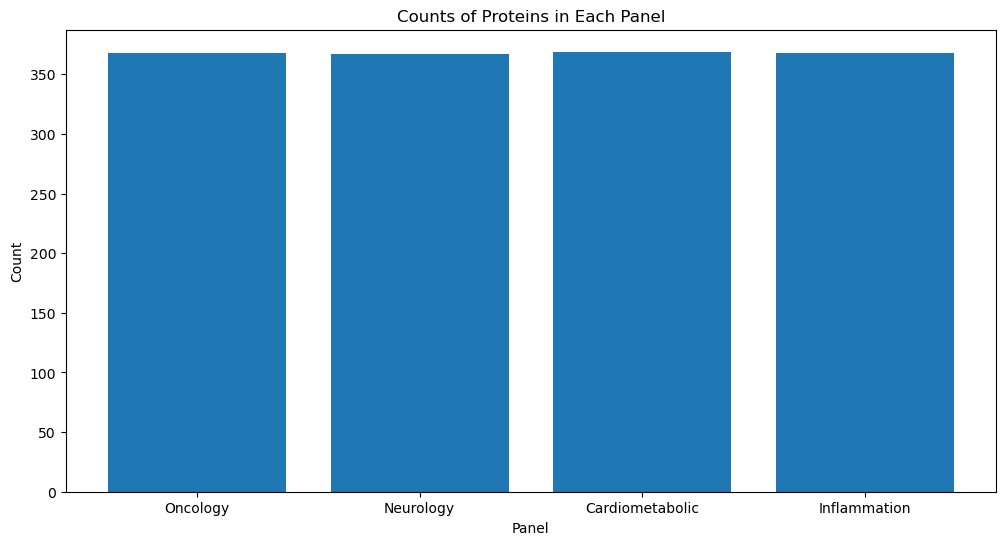

In [18]:
panel_protein_count = []

for panel in D0_olink['Panel'].unique():
    panel_proteins = D0_olink[D0_olink['Panel'] == panel]
    panel_proteins = panel_proteins['UniProt'].unique()
    panel_protein_count.append(len(panel_proteins))

plt.figure(figsize=(12, 6))
plt.bar(x=[panel for panel in D0_olink['Panel'].unique()], height=panel_protein_count)
plt.title('Counts of Proteins in Each Panel')
plt.xlabel('Panel')
plt.ylabel('Count')
plt.xticks()
plt.show()    


It looks like the four panels range from Oncology, Neurology, Cardiometabolic, and Inflammation. It seems as if there are equal amount of proteins in each one of those panels. I don't know enough about sequencing to say whether this is a good thing or not, but I do think it is a valuable to have a nice spread for the underlining biological processes. When I do the feature extraction later on, I want to redo this chart but with the best proteins--mostly out of my curiousity.

In [19]:
QC_warn = D0_olink[D0_olink['QC_Warning'] != 'PASS']
QC_warn_proteins = QC_warn['UniProt'].unique()
QC_warn_subject_id = QC_warn['subject_id'].unique()

print(len(QC_warn_proteins))
print(len(QC_warn_subject_id))

1146
38


For the data with quality control warnings, there were 1146 unique proteins and 38 subject_ids. The amount of proteins that had QC warnings is a little bit alarming to me given that there are only 1463 proteins in this study. On the other hand, there are only 38 subject_ids that have the QC warning. I want to check to see if those 38 subject_ids share similar or different proteins. Depending on what that shows, it could help me construct the dataset to do the feature extraction on.

This is for me to see where the QC_Warning gives a warning in the D0_draw dataset for the proteins. I am curious if these values are where the NPX value is lower than the LOD. I don’t remember if I talked about this already, but on Olink’s website, they recommend still doing an analysis of the proteins that have a lower NPX score than LOD score. The reason that they recommend doing that is because it can explain the nonlinear nature of the dataset.

Let’s check if my hypothesis is true, I have a feeling that it is false given that Olink says that the NPX < LOD should still be considered in the data for the nonlinear aspect of the data.

In [20]:
QC_warn_diff = QC_warn['NPX'] - QC_warn['LOD'] 
QC_warn_diff_neg = QC_warn_diff[QC_warn_diff < 0]

print(f"Hypothesis = {len(QC_warn_diff) - len(QC_warn_diff_neg) == 0}")

Hypothesis = False


I was wrong about my hypothesis in the markdown blob just above. That is totally fine, I was mostly just curious. Let's go onto seeing how the subject_ids compare to each other with QC warnings.


In [21]:
id_list = []
id_protein_dic = {}

for _id in QC_warn_subject_id:
    id_list.append(_id)
    subject_id_proteins = QC_warn[QC_warn['subject_id'] == _id]
    subject_id_proteins = subject_id_proteins['UniProt'].unique()
    id_protein_dic[_id] = subject_id_proteins
    print(len(id_protein_dic[_id]))

347
185
76
106
347
62
106
71
110
76
110
80
110
106
114
71
185
80
110
110
110
105
114
280
71
110
80
71
71
185
106
147
71
106
114
110
218
80


It is easy to see that each one of those subject_ids has a different amount of proteins that have QC warnings. This leads into a few thoughts about these 36 subject_ids. I am curious about how strong of a sample these 36 subject_ids are and whether or not I should use them for my feature selection. To be able to assess that, I am going to do two PCA plots. One with all the subject_ids and the other with no subject_ids that have QC warnings.

Since the NPX value is already normalized to reduce intra- and inter-assay variation, I am not going to standardize the data so each protein column has mean 0 and variance 1. I believe that the way Olink did it is already suitable. First, I have to import PCA from sklearn.

In [22]:
from sklearn.decomposition import PCA

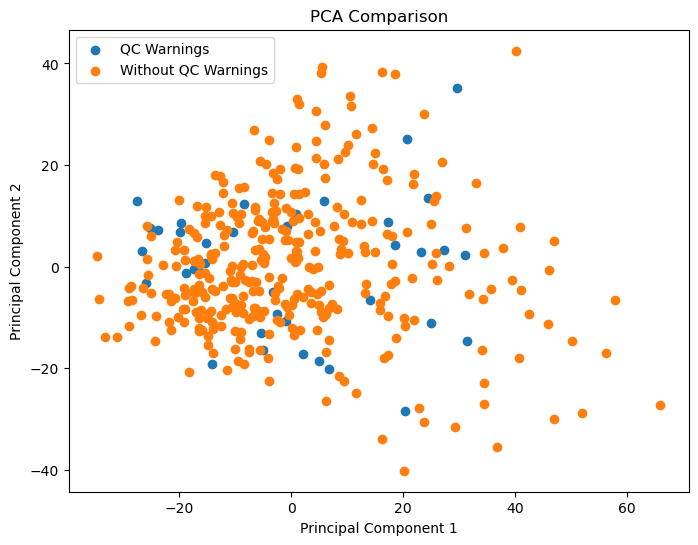

In [23]:
D0_proteins = D0_olink.pivot_table(index = 'subject_id', columns = 'UniProt', values = 'NPX')

D0_proteins_no_warnings = D0_proteins.drop(id_list, errors='ignore')
D0_proteins_with_warnings = D0_proteins.loc[id_list]

pca = PCA()
pca_with_warnings = pca.fit_transform(D0_proteins_with_warnings)
pca_with_no_warnings = pca.fit_transform(D0_proteins_no_warnings)

pca_with_warnings = pd.DataFrame(data = pca_with_warnings)
pca_with_no_warnings = pd.DataFrame(data = pca_with_no_warnings)

plt.figure(figsize=(8,6))
plt.scatter(pca_with_warnings.iloc[:, 0], pca_with_warnings.iloc[:, 1], label='QC Warnings')
plt.scatter(pca_with_no_warnings.iloc[:, 0], pca_with_no_warnings.iloc[:, 1], label='Without QC Warnings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Comparison')
plt.legend()
plt.show()

From the PCA plot above, I was comparing the samples that have QC warnings (in blue) and without QC warnings (in orange). The blue dots are within the distribution of the orange dots. This tells me that I don’t necessarily have to get rid of their data. If my results for the protein extraction and classification model don’t work as well as I would like, I might go back and see how those models work without the QC warning samples.

The last thing that I am going to check with the QC warnings is how many of those QC_warning subject_ids have COVID or not.

In [24]:
clinical_QC_warnings = clinical_data[clinical_data['subject_id'].isin(id_list)][['subject_id', 'COVID']]
print(f"{clinical_QC_warnings['COVID'].sum() / len(clinical_QC_warnings)}% of QC warning subject_ids have covid")

0.7368421052631579% of QC warning subject_ids have covid


This is about the 80/20 the data is split for COVID/no COVID. It's nice to see that the QC_warning has warnings close to evenly throughout the data.

The next part I am going to look at are the assay warnings. It is good to go through the omic datasets and look at where there are warnings.

In [25]:
assay_warn = D0_olink[D0_olink['Assay_Warning'] != 'PASS']
assay_warn_proteins = assay_warn['UniProt'].unique()
assay_warn_subject_id = assay_warn['subject_id'].unique()

print(len(assay_warn_proteins))
print(len(assay_warn_subject_id))

9
270


So there are 9 proteins that have assay warnings. With that, there are 270 subject_ids that have at least one protein that has an assay warning. My first thought is that with the assay giving a warning for roughly 70% of the subject_ids, there is probably something that is "wrong" with those assays that caused a lot of the subject_ids to have the warning there.

The next thing I am going to do is to group together how many subject_ids failed per protein. I am also going to see the difference between the LOD and NPX like I did for the QC warnings, because I am curious.

In [26]:
assay_warn_diff = assay_warn['NPX'] - assay_warn['LOD'] 
assay_warn_diff_neg = assay_warn_diff[assay_warn_diff < 0]

print(f"All NPX < LOD : {len(QC_warn_diff) - len(QC_warn_diff_neg) == 0}")

All NPX < LOD : False


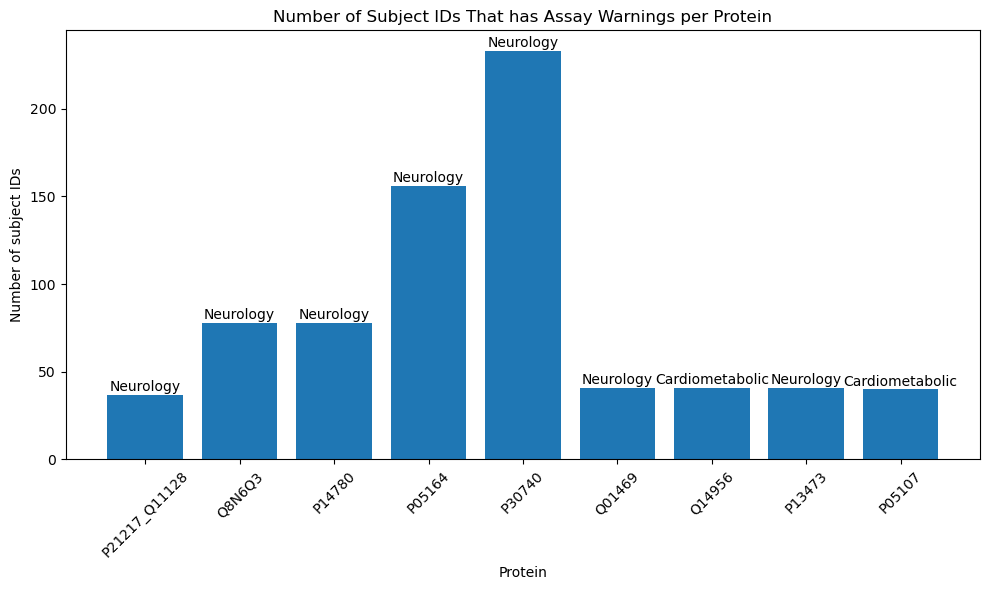

In [27]:
assay_protein_subject_id_dic = {}
assay_protein_panel = {}

for protein in assay_warn_proteins:
    assay_protein_df = assay_warn[assay_warn['UniProt'] == protein]
    assay_protein_subject_id_dic[protein] = len(assay_protein_df['subject_id'].tolist())  # Convert Series to list and then get the length
    assay_protein_panel[protein] = assay_protein_df['Panel'].unique()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(assay_protein_subject_id_dic)), list(assay_protein_subject_id_dic.values()), align='center')
plt.xticks(range(len(assay_protein_subject_id_dic)), assay_protein_subject_id_dic.keys(), rotation=45)
plt.xlabel('Protein')
plt.ylabel('Number of subject IDs')
plt.title('Number of Subject IDs That has Assay Warnings per Protein')

# Adding panel labels
for i, protein in enumerate(assay_protein_panel):
    panels = ','.join(assay_protein_panel[protein])
    plt.text(i, list(assay_protein_subject_id_dic.values())[i] + 2, panels, ha='center')

plt.tight_layout()
plt.show()    

This chart here describes what part of the data has the assay warnings. The name above the bar is the panel that protein is from, and the height of the bar is representing how many subject_ids have warnings for that protein.

I find it interesting that 7/9 of those proteins come from the Neurology panel and the other two come from the Cardiometabolic panel. It makes me wonder why it is heavily weighted towards the neurology panel and if it is a sequencing issue or just a lack of information about those proteins.

I don't like how over 50% of the subject_ids have an assay warning for P05164 and P30740 proteins. This tells me that there was something wrong with the assay itself, and that I should probably not include those proteins in my statistical analysis further down on this page. It is questionable if the other 7 proteins should be included or not. I would like to know more on the sequencing side and what Olink would recommend doing about those ones. The fact that there are 9 proteins that had assay warnings, these proteins might skew the analysis and give a result that might not be able to be generalizable. 

After finding the Assay warning part on Olink's website, I have decided that I am going to get rid of each one of those proteins. The reason that I am going to get rid of the proteins is because Olink says that if the assay warning comes back as warning, there was something wrong with the sequencing itself. Since each one of those looks to have at least 10% of the datapoints, I am going to get rid of each of those proteins. I don't want those in my dataset because it can easily skew what I am trying to show.

If I had more time, I would want to go through this dataset more. I would want to try to get a better understanding of how the QC and Assay warnings affect the system and see how they are in the COVID positive and negative samples. I would also want to see how much of the proteomics data has the NPX < LOD, because it could help explain the nonlinearity of the system. But for now, let's get on to the analysis :).

## Feature Selection

Before I go into the feature extarction, I want to recap how I am going to design my dataset. I am only going to be looking at the day 0 draw because that is where the most amount of samples are at. I am going to use the amount of samples with day 0 draw from the Olink dataset because it had one less sample than the clinical information dataset. From there, I am going to get rid of proteins with the assay warnings.

So, from Olink dataset make the $X$ matrix of (subject_id x proteins) where the values are the NPX value. Get the $y$ vector from the clinical dataset of (subject_id x Covid). Then to make it easier for me, I'll make it into one pandas dataframe.

In [28]:
from sklearn.model_selection import train_test_split

In [67]:
class get_data:
    def __init__(self):
        self.clinical = pd.read_csv("MGH_COVID_Clinical_Info.txt", delimiter = ";")
        self.olink = pd.read_csv("MGH_COVID_OLINK_NPX.txt", delimiter = ";")
        self.dataset = None

    def load_dataset(self):
        D0_data = self.olink[self.olink['Timepoint'] == 'D0']
        D0_proteins = D0_data.pivot_table(index = 'subject_id', columns = 'UniProt', values = 'NPX')
        D0_proteins.reset_index(inplace = True)
        D0_proteins = pd.merge(D0_proteins, self.clinical[['subject_id', 'COVID']], on = 'subject_id', how = 'left')
        
        assay_warn = D0_data[D0_data['Assay_Warning'] != 'PASS']
        assay_warn_proteins = assay_warn['UniProt'].unique()
        
        D0_proteins = D0_proteins.drop(columns = assay_warn_proteins, errors='ignore')
        self.dataset = D0_proteins.drop(columns = 'subject_id')
        
        return self.dataset
        
    def split_data(self, best_proteins):
        self.load_dataset
        self.dataset = self.dataset.loc[:, best_proteins + ['COVID']]

        X = self.dataset.drop('COVID', axis = 1)
        y = self.dataset['COVID']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 54)
        
        datasets = {
            'train': {
                'X': X_train, 
                'y': y_train
            },
            'test': {
                'X': X_test, 
                'y': y_test
            }
        }
        
        return datasets

### T-Test / Volcano plot
I am going to extract the proteins here using a t-test and vizualize it via a volcano plot. The t-test works because we are assuming the null hypothesis is that the proteins means are going to be the same in the covid positive and the covid negative, where the alternative hypothesis is that they are not the same. The t-test will be able to give us the fold change (difference of means) and p-value (statistical significance) of the proteins. The lower the p-value, the more unlikely they are to be in our null hypothesises. This is great because it lets us determine what is unlikely different protein concentrations in our data. This will be able to give us a set of "best proteins" to be able to run the classification on. Instead of writing it all out, I am going to use scipy prebuilt t-test command.

In [102]:
from scipy.stats import ttest_ind
import numpy as np

In [31]:
def perform_ttest(df):
    disease_df = df[df['COVID'] == 1].drop('COVID', axis = 1)
    control_df = df[df['COVID'] == 0].drop('COVID', axis = 1)

    proteins = disease_df.columns

    fold_changes = []
    p_values = []

    for protein in proteins:
        disease_npx = disease_df[protein]
        control_npx = control_df[protein]

        fold_change = disease_npx.mean() - control_npx.mean()
        fold_changes.append(fold_change)

        t_stat, p_value = ttest_ind(disease_npx, control_npx)
        p_values.append(p_value)

    ttest_df = pd.DataFrame({
        'Protein': proteins,
        'Fold Change': fold_changes,
        'P-value': p_values
    })
    
    return ttest_df

In [32]:
got_data = get_data()
df = got_data.load_dataset()

/var/folders/pw/0xzx218d3bd3znkygcp44dbc0000gn/T/ipykernel_56280/2177734502.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  self.olink = pd.read_csv("MGH_COVID_OLINK_NPX.txt", delimiter = ";")


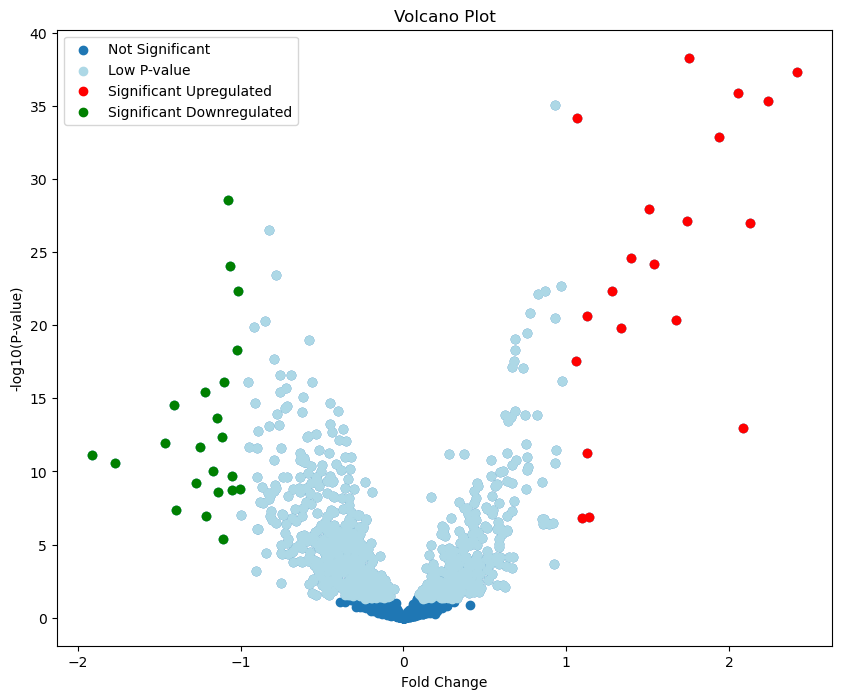

In [33]:
result_df = perform_ttest(df)
result_df['-log10(P-value)'] = -np.log10(result_df['P-value'])

plt.figure(figsize = (10, 8))
plt.scatter(result_df['Fold Change'], result_df['-log10(P-value)'], label = 'Not Significant')

low_p_value = result_df[result_df['-log10(P-value)'] > 1.3]
plt.scatter(low_p_value['Fold Change'], low_p_value['-log10(P-value)'], color = 'lightblue', label = 'Low P-value')

significant_upregulated = result_df[(result_df['Fold Change'] > 1) & (result_df['-log10(P-value)'] > 1.3)]
plt.scatter(significant_upregulated['Fold Change'], significant_upregulated['-log10(P-value)'], color = 'red', label = 'Significant Upregulated')

significant_downregulated = result_df[(result_df['Fold Change'] < -1) & (result_df['-log10(P-value)'] > 1.3)]
plt.scatter(significant_downregulated['Fold Change'], significant_downregulated['-log10(P-value)'], color = 'green', label = 'Significant Downregulated')
# plt.axhline(y = threshold, color = 'blue', linestyle = '--', label = 'Top 100 Proteins')

plt.legend(loc='best')
plt.xlabel('Fold Change')
plt.ylabel('-log10(P-value)')
plt.title('Volcano Plot')

plt.show()

I did a few things there, and I know where I want to go next. What I did was a t-test to construct a volcano plot. In the plot I have a few different areas. The light blue are proteins with less than 0.05 for the p-value. The green dots are the significant downregulated; while the red dots are the significant upregulated. I chose significance based upon the p-value and the fold change. Since Olink's NPX value is $log_2$, it means concentrations are either 1/2 or doubled to each other. Those for a random forest classification could be a good idea to include because they still hold statistical significance and in my mind it seems like there will be an easy seperator for the random forest to learn.

Where I want to go to next is a L1 logistic regression with the top 100 proteins union the significant up/downregulated proteins. I am wanting to use L1 regularization because it is going to help keep sparsity; which means it tends to push feature coefficients to zero, effectively performing feature selection. This would give me another collection of proteins to train the classifier in the following step. As I want to compare AUC to see what model would perform the best.

To be able to get there, I am going to rewrite what I have done for the volcano plot, but in a class so I can use it a little bit easier. Most of it will be copy and past from above.

In [34]:
class VolcanoPlot:
    def __init__(self, df):
        self.df = df
        self.ttest_df = None
        self.top_proteins = None
        self.significant_upregulated = None
        self.significant_downregulated = None

    def perform_ttest(self):
        disease_df = df[df['COVID'] == 1].drop('COVID', axis = 1)
        control_df = df[df['COVID'] == 0].drop('COVID', axis = 1)

        proteins = disease_df.columns

        fold_changes = []
        p_values = []

        for protein in proteins:
            disease_npx = disease_df[protein]
            control_npx = control_df[protein]

            fold_change = disease_npx.mean() - control_npx.mean()
            fold_changes.append(fold_change)

            t_stat, p_value = ttest_ind(disease_npx, control_npx)
            p_values.append(p_value)

        self.ttest_df = pd.DataFrame({
            'Proteins': proteins,
            'Fold Change': fold_changes,
            'P-value': p_values
        })
    
    def prepare_data(self):
        self.perform_ttest()
        
        self.ttest_df['-log10(P-value)'] = -np.log10(self.ttest_df['P-value'])
        self.ttest_df.sort_values(by='-log10(P-value)', ascending=False, inplace=True)
        
        self.top_proteins = self.ttest_df.head(100)
        self.significant_upregulated = self.ttest_df[(self.ttest_df['Fold Change'] > 1) & (self.ttest_df['-log10(P-value)'] > 1.3)]
        self.significant_downregulated = self.ttest_df[(self.ttest_df['Fold Change'] < -1) & (self.ttest_df['-log10(P-value)'] > 1.3)]
        
        return self.top_proteins['Proteins'], self.significant_upregulated['Proteins'], self.significant_downregulated['Proteins']

    def plot(self):
        plt.figure(figsize = (10, 8))
        plt.scatter(self.ttest_df['Fold Change'], self.ttest_df['-log10(P-value)'], label = 'Not Significant')

        low_p_value = self.ttest_df[self.ttest_df['-log10(P-value)'] > 1.3]
        plt.scatter(low_p_value['Fold Change'], low_p_value['-log10(P-value)'], color = 'lightblue', label = 'Low P-value')

        plt.scatter(self.significant_upregulated['Fold Change'], self.significant_upregulated['-log10(P-value)'], color = 'red', label = 'Significant Upregulated')
        plt.scatter(self.significant_downregulated['Fold Change'], self.significant_downregulated['-log10(P-value)'], color = 'green', label = 'Significant Downregulated')
        plt.scatter(self.top_proteins['Fold Change'], self.top_proteins['-log10(P-value)'], color = 'black', label = 'Top 100 Proteins')

        plt.title('Volcano Plot')
        plt.legend(loc = 'best')
        plt.xlabel('Fold Change')
        plt.ylabel('-log10(P-value)')
        
        plt.show()

/var/folders/pw/0xzx218d3bd3znkygcp44dbc0000gn/T/ipykernel_56280/2177734502.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  self.olink = pd.read_csv("MGH_COVID_OLINK_NPX.txt", delimiter = ";")


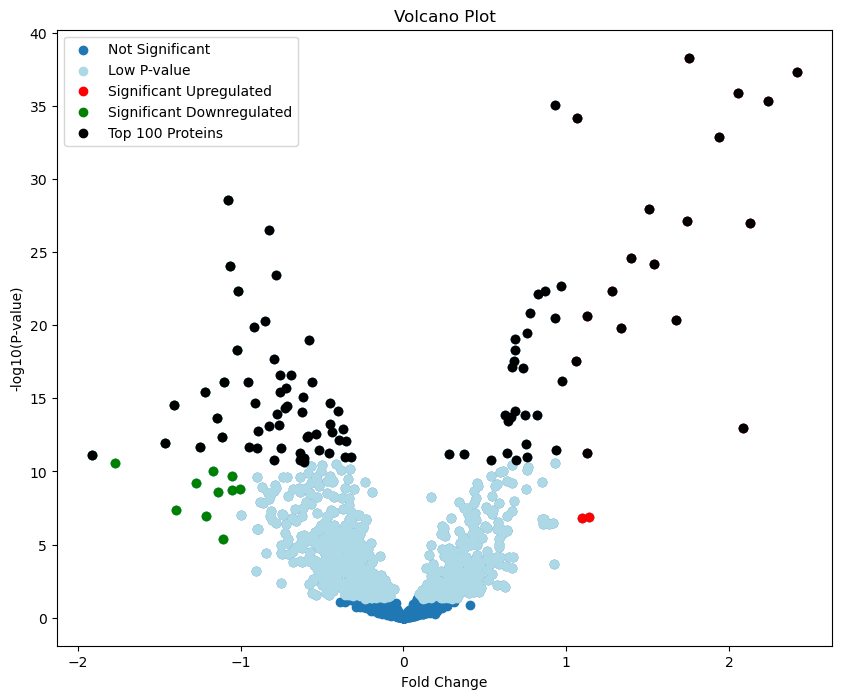

In [35]:
got_data = get_data()
df = got_data.load_dataset()

volcano = VolcanoPlot(df)
top_100, sig_up, sig_down = volcano.prepare_data()
volcano.plot()

### L1 Logistic Regression
As talked about already, L1 logistic regression wil be able to get a smaller selction of proteins. Here I am going to combine the green, red, and black proteins together and run it on that. I'm curious to see if the red or green ones are going to be some of the proteins that have the heaviest weights.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

In [37]:
got_data = get_data()
df = got_data.load_dataset()

volcano = VolcanoPlot(df)
top_100, sig_up, sig_down = volcano.prepare_data()

best_proteins = set()
best_proteins.update(top_100)
best_proteins.update(sig_up)
best_proteins.update(sig_down)
best_proteins = list(best_proteins)

dataset_dic = got_data.split_data(best_proteins)

/var/folders/pw/0xzx218d3bd3znkygcp44dbc0000gn/T/ipykernel_56280/2177734502.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  self.olink = pd.read_csv("MGH_COVID_OLINK_NPX.txt", delimiter = ";")


Shape of X_train: (306, 112)
Shape of X_train_best: (306, 44)
Shape of X_test_best: (77, 44)


/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


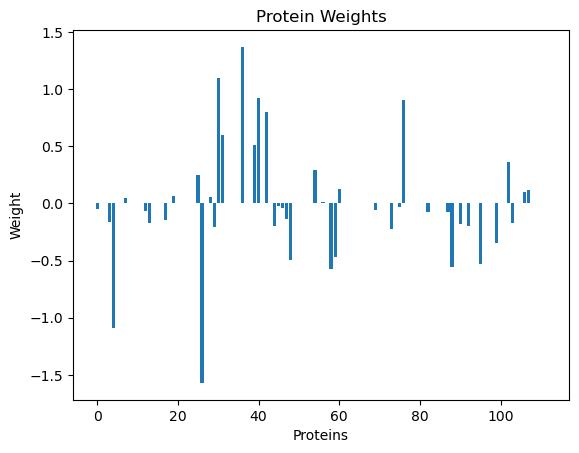

In [68]:
lr = LogisticRegression(penalty = 'l1', solver = 'liblinear')

lr.fit(dataset_dic['train']['X'], dataset_dic['train']['y'])

coefficients = lr.coef_
selector = SelectFromModel(estimator = lr, prefit = True)

X_train_best = selector.transform(dataset_dic['train']['X'])
X_test_best = selector.transform(dataset_dic['test']['X'])

print("Shape of X_train:", dataset_dic['train']['X'].shape)
print("Shape of X_train_best:", X_train_best.shape)
print("Shape of X_test_best:", X_test_best.shape)


coefficients = lr.coef_[0]

x = np.arange(len(coefficients))

plt.bar(x, coefficients)
plt.xlabel('Proteins')
plt.ylabel('Weight')
plt.title('Protein Weights')

plt.show()

Proof of concept that I want to do shows that this works. The bar chart above shows the weight of the proteins and their affect they have on the system. The positive weights would signify the upregulated proteins, the negative weights would signify the downregulated proteins. 

Like I did above, I am going to rewrite this into a class to make it into a class to be easier to use further down. There are a few more things that I am going to do in that class because I am actually curious about the proteins that are being extracted. The way that I have it currently shows what features without names and I want to extract the names of the proteins, too.

As there are more things that I want to do with this project, I don't think I'll have enough time to do it all. I am going to change my way of doing what I want to show. At first I wasted to do extracted proteins -> random forest, but now I am just going to keep it as a l1 logistic regression with a hyperparameter search.

In [82]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [74]:
class LASSO:
    def __init__(self, dataset_dic):
        self.df = dataset_dic
        self.X_train = self.df['train']['X']
        self.y_train = self.df['train']['y']
        self.X_test = self.df['test']['X']
        self.y_test = self.df['test']['y']
        
        self.lr = LogisticRegression(penalty = 'l1', solver = 'liblinear')
        self.coefficients = None
        self.selector = None
        
        self.rf = RandomForestClassifier(n_estimators=75, criterion='entropy')
        self.X_train_best = None
        self.X_test_best = None
        
    def train(self):
        self.lr.fit(self.X_train, self.y_train)
        self.coefficients = self.lr.coef_[0]
    
    def extract(self, len_proteins = None):
        if len_proteins != None:
            threshold = np.sort(np.abs(self.coefficients))[-len_proteins]
        else:
            threshold = None
        
        self.selector = SelectFromModel(estimator = self.lr, prefit = True, threshold = threshold)

        self.X_train_best = self.selector.transform(self.X_train)
        self.X_test_best = self.selector.transform(self.X_test)
        
    def plot_all_proteins(self):
        coefficients = self.lr.coef_[0]

        x = np.arange(len(coefficients))

        plt.bar(x, coefficients)
        plt.xlabel('Proteins')
        plt.ylabel('Weight')
        plt.title('Protein Weights')

        plt.show()
    
    def plot_best_proteins(self):
        selected_features = self.selector.get_support(indices=True)
        selected_coefficients = self.coefficients[selected_features]

        x = np.arange(len(selected_coefficients))

        plt.bar(x, selected_coefficients)
        plt.xlabel('Selected Proteins')
        plt.ylabel('Weight')
        plt.title('Weights of Selected Proteins')

        plt.show()    
        
    def evaluate(self):
        self.lr.fit(self.X_train_best, self.y_train)
        y_pred = self.lr.predict(self.X_test_best)

        accuracy = accuracy_score(self.y_test, y_pred)

        y_pred_prob = self.lr.predict_proba(self.X_test_best)[:, 1]
        auc = roc_auc_score(self.y_test, y_pred_prob)

        print("Test Accuracy:", accuracy)
        print("Test AUC:", auc)
        
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_prob)

        plt.figure()
        plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
    def evaluate_rf(self):
        self.rf.fit(self.X_train_best, self.y_train)
        y_pred = self.rf.predict(self.X_test_best)

        accuracy = accuracy_score(self.y_test, y_pred)

        y_pred_prob = self.rf.predict_proba(self.X_test_best)[:, 1]
        auc = roc_auc_score(self.y_test, y_pred_prob)

        print("Test Accuracy:", accuracy)
        print("Test AUC:", auc)
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_prob)

        plt.figure()
        plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

/var/folders/pw/0xzx218d3bd3znkygcp44dbc0000gn/T/ipykernel_56280/2177734502.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  self.olink = pd.read_csv("MGH_COVID_OLINK_NPX.txt", delimiter = ";")
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


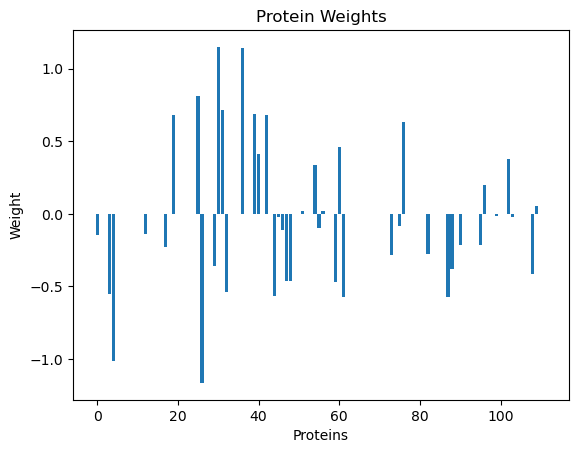

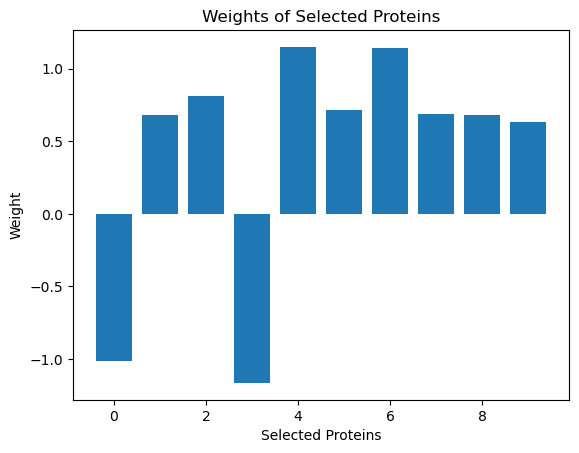

Test Accuracy: 0.974025974025974
Test AUC: 0.9934086629001883


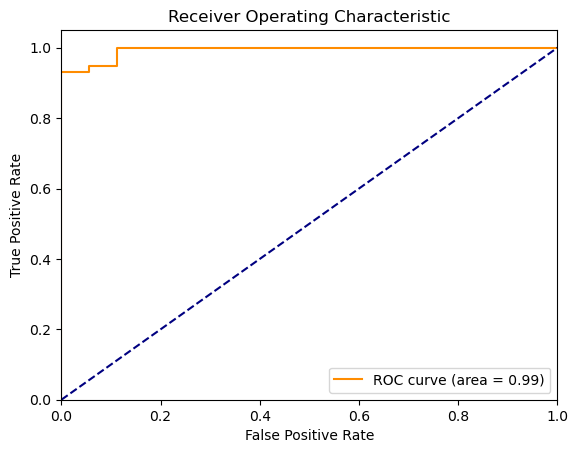

Test Accuracy: 0.961038961038961
Test AUC: 0.9774011299435028


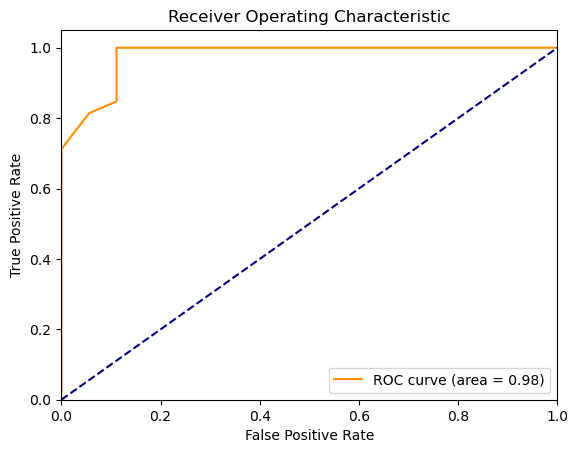

In [81]:
got_data = get_data()
df = got_data.load_dataset()

volcano = VolcanoPlot(df)
top_100, sig_up, sig_down = volcano.prepare_data()

best_proteins = set()
best_proteins.update(top_100)
best_proteins.update(sig_up)
best_proteins.update(sig_down)
best_proteins = list(best_proteins)

dataset_dic = got_data.split_data(best_proteins)

lasso = LASSO(dataset_dic)
lasso.train()
lasso.extract(10)
lasso.plot_all_proteins()
lasso.plot_best_proteins()
lasso.evaluate()
lasso.evaluate_rf()

## Classification Model W/ Hyperparameter Search
On this part I am going to take what I have above and collect it together. I am wanting to have three classes: data, volcano, and classifier. The data is going to be dealing with the data part, the volcano is for the t-test and volcano plot, and the classifier is going to be the lasso and logistic regression classifier with a hyperparameter search.

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Scikit-learn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression


In [83]:
class get_data:
    def __init__(self):
        self.clinical = pd.read_csv("MGH_COVID_Clinical_Info.txt", delimiter = ";")
        self.olink = pd.read_csv("MGH_COVID_OLINK_NPX.txt", delimiter = ";")
        self.dataset = None

    def load_dataset(self):
        D0_data = self.olink[self.olink['Timepoint'] == 'D0']
        D0_proteins = D0_data.pivot_table(index = 'subject_id', columns = 'UniProt', values = 'NPX')
        D0_proteins.reset_index(inplace = True)
        D0_proteins = pd.merge(D0_proteins, self.clinical[['subject_id', 'COVID']], on = 'subject_id', how = 'left')
        
        assay_warn = D0_data[D0_data['Assay_Warning'] != 'PASS']
        assay_warn_proteins = assay_warn['UniProt'].unique()
        
        D0_proteins = D0_proteins.drop(columns = assay_warn_proteins, errors='ignore')
        self.dataset = D0_proteins.drop(columns = 'subject_id')
        
        return self.dataset
        
    def split_data(self, best_proteins):
        self.load_dataset
        self.dataset = self.dataset.loc[:, best_proteins + ['COVID']]

        X = self.dataset.drop('COVID', axis = 1)
        y = self.dataset['COVID']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 54)
        
        datasets = {
            'train': {
                'X': X_train, 
                'y': y_train
            },
            'test': {
                'X': X_test, 
                'y': y_test
            }
        }
        
        return datasets

In [181]:
class VolcanoPlot:
    def __init__(self, df):
        self.df = df
        self.ttest_df = None
        self.top_proteins = None
        self.significant_upregulated = None
        self.significant_downregulated = None

    def perform_ttest(self):
        disease_df = df[df['COVID'] == 1].drop('COVID', axis = 1)
        control_df = df[df['COVID'] == 0].drop('COVID', axis = 1)

        proteins = disease_df.columns

        fold_changes = []
        p_values = []

        for protein in proteins:
            disease_npx = disease_df[protein]
            control_npx = control_df[protein]

            fold_change = disease_npx.mean() - control_npx.mean()
            fold_changes.append(fold_change)

            t_stat, p_value = ttest_ind(disease_npx, control_npx)
            p_values.append(p_value)

        self.ttest_df = pd.DataFrame({
            'Proteins': proteins,
            'Fold Change': fold_changes,
            'P-value': p_values
        })

    def prepare_data(self):
        self.perform_ttest()

        self.ttest_df['-log10(P-value)'] = -np.log10(self.ttest_df['P-value'])
        self.ttest_df.sort_values(by='-log10(P-value)', ascending=False, inplace=True)

        self.top_proteins = self.ttest_df.head(100)
        self.significant_upregulated = self.ttest_df[(self.ttest_df['Fold Change'] > 1) & (self.ttest_df['-log10(P-value)'] > 1.3)]
        self.significant_downregulated = self.ttest_df[(self.ttest_df['Fold Change'] < -1) & (self.ttest_df['-log10(P-value)'] > 1.3)]

        return self.top_proteins['Proteins'], self.significant_upregulated['Proteins'], self.significant_downregulated['Proteins']

    def plot(self):
        plt.figure(figsize = (10, 8))
        plt.scatter(self.ttest_df['Fold Change'], self.ttest_df['-log10(P-value)'], label = 'Not Significant')

        low_p_value = self.ttest_df[self.ttest_df['-log10(P-value)'] > 1.3]
        plt.scatter(low_p_value['Fold Change'], low_p_value['-log10(P-value)'], color = 'lightblue', label = 'Low P-value')

        plt.scatter(self.significant_upregulated['Fold Change'], self.significant_upregulated['-log10(P-value)'], color = 'red', label = 'Significant Upregulated')
        plt.scatter(self.significant_downregulated['Fold Change'], self.significant_downregulated['-log10(P-value)'], color = 'green', label = 'Significant Downregulated')
        plt.scatter(self.top_proteins['Fold Change'], self.top_proteins['-log10(P-value)'], color = 'black', label = 'Top 100 Proteins')

        plt.title('Volcano Plot')
        plt.legend(loc = 'best')
        plt.xlabel('Fold Change')
        plt.ylabel('-log10(P-value)')

        plt.show()
    
    def plot_best_proteins(self, best_proteins):
        plt.figure(figsize = (10, 8))
        plt.scatter(self.ttest_df['Fold Change'], self.ttest_df['-log10(P-value)'], label = 'Other Proteins')
        
        best_proteins_df = self.ttest_df[self.ttest_df['Proteins'].isin(best_proteins)]
        plt.scatter(best_proteins_df['Fold Change'], best_proteins_df['-log10(P-value)'], color = 'red', label = f'Best {len(best_proteins)} Proteins')
       
        plt.title('Volcano Plot')
        plt.legend(loc = 'best')
        plt.xlabel('Fold Change')
        plt.ylabel('-log10(P-value)')

        plt.show()

In [182]:
class Logistic_Regression:
    def __init__(self, dataset_dic):
        self.df = dataset_dic
        self.X_train = self.df['train']['X']
        self.y_train = self.df['train']['y']
        self.X_test = self.df['test']['X']
        self.y_test = self.df['test']['y']
        
        self.lr = LogisticRegression(penalty = 'l1', solver = 'liblinear')
        self.coefficients = None
        self.selector = None
        
        self.X_train_best = None
        self.X_test_best = None
        self.best_param = None
        
    def train(self):
        self.lr.fit(self.X_train, self.y_train)
        self.coefficients = self.lr.coef_[0]
    
    def LASSO(self, len_proteins = None):
        if len_proteins != None:
            threshold = np.sort(np.abs(self.coefficients))[-len_proteins]
        else:
            threshold = None
        
        self.selector = SelectFromModel(estimator = self.lr, prefit = True, threshold = threshold)
        
        self.X_train_best = self.selector.transform(self.X_train)
        self.X_test_best = self.selector.transform(self.X_test)
        
        return self.X_train_best
        
    def plot_all_proteins(self):
        x = np.arange(len(self.coefficients))

        plt.bar(x, self.coefficients)
        plt.xlabel('Proteins')
        plt.ylabel('Weight')
        plt.title('Protein Weights')

        plt.show()
    
    def plot_best_proteins(self, num_proteins):
        selected_features = self.selector.get_support(indices=True)
        selected_coefficients = self.coefficients[selected_features]

        x = np.arange(len(selected_coefficients))

        plt.bar(x, selected_coefficients)
        plt.xlabel('Selected Proteins')
        plt.ylabel('Weight')
        plt.title(f'Weights of {num_proteins} Selected Proteins')

        plt.show()    
   
    def hyperparam_search(self, param_grid):
        lr = LogisticRegression()
        grid_search = GridSearchCV(lr, param_grid, cv = 10, scoring='accuracy')
        grid_search.fit(self.X_train_best, self.y_train)

        self.best_params = grid_search.best_params_

        print("Best Hyperparameters: ", self.best_params)
        
    def evaluate(self):
        best_model = LogisticRegression(C = self.best_params['C'], penalty = self.best_params['penalty'], solver = self.best_params['solver'])
        best_model.fit(self.X_train_best, self.y_train)
        y_pred = best_model.predict(self.X_test_best)

        self.lr.fit(self.X_train_best, self.y_train)
        y_pred = self.lr.predict(self.X_test_best)

        accuracy = accuracy_score(self.y_test, y_pred)

        y_pred_prob = best_model.predict_proba(self.X_test_best)[:, 1]
        auc = roc_auc_score(self.y_test, y_pred_prob)

        print("Test Accuracy:", accuracy)
        print("Test AUC:", auc)
        
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_prob)

        return accuracy, auc, (fpr, tpr)
        


In [183]:
def get_protein_names(A, B):
    B = pd.DataFrame(B)
    
    assert A.shape[0] == B.shape[0], "Number of rows in A and B must be the same"
    assert A.shape[1] >= B.shape[1], "Number of columns in A must be greater than or equal to B"

    column_names = []
    for i in range(B.shape[1]):
        for col in A.columns:
            if np.all(A[col].to_numpy() == B.iloc[:, i].to_numpy()):
                column_names.append(col)
                break

    return column_names


/var/folders/pw/0xzx218d3bd3znkygcp44dbc0000gn/T/ipykernel_56280/2177734502.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  self.olink = pd.read_csv("MGH_COVID_OLINK_NPX.txt", delimiter = ";")


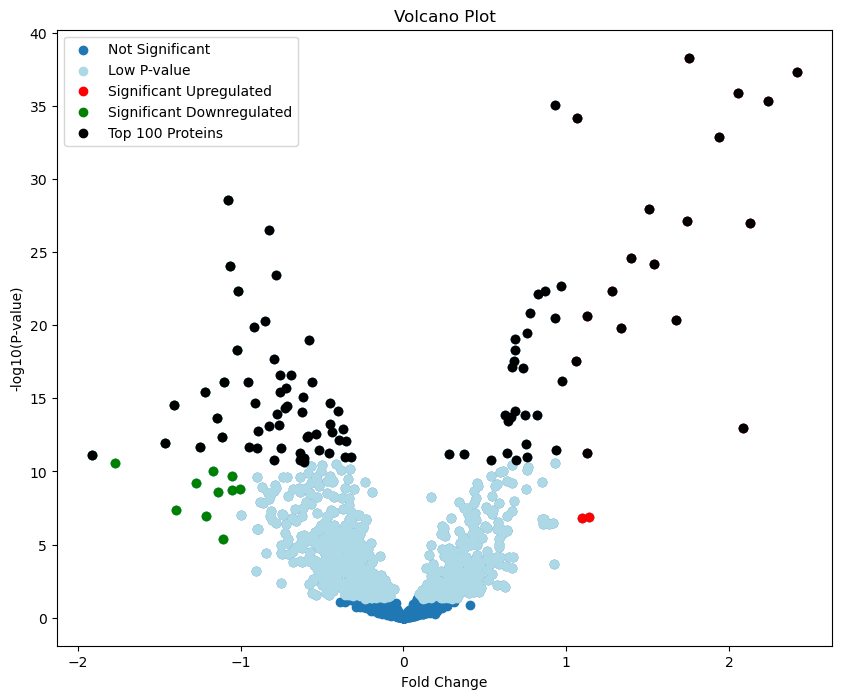

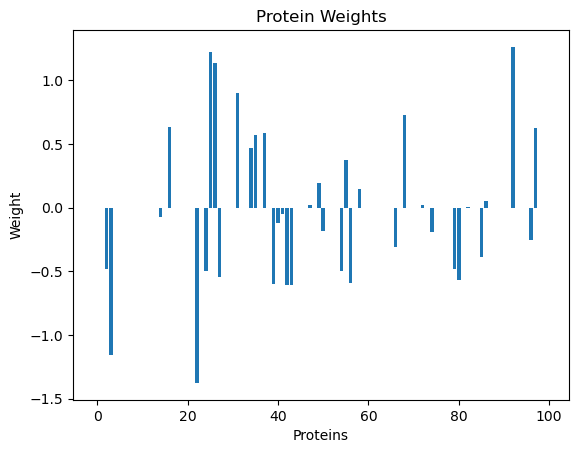

/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py

Best Hyperparameters:  {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.8181818181818182
Test AUC: 0.7203389830508475
Best Hyperparameters:  {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.9090909090909091
Test AUC: 0.9463276836158192
Best Hyperparameters:  {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.974025974025974
Test AUC: 0.9981167608286252
Best Hyperparameters:  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.974025974025974
Test AUC: 0.9971751412429378


/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Best Hyperparameters:  {'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.935064935064935
Test AUC: 0.9708097928436912


/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/connorrice/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


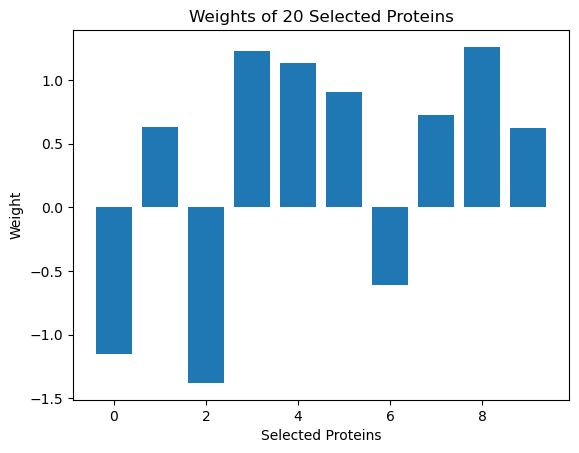

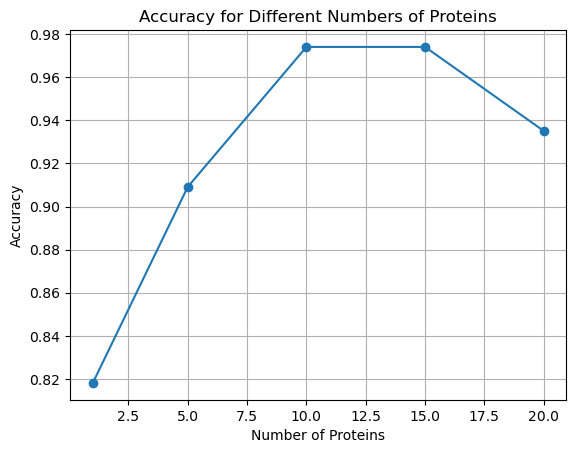

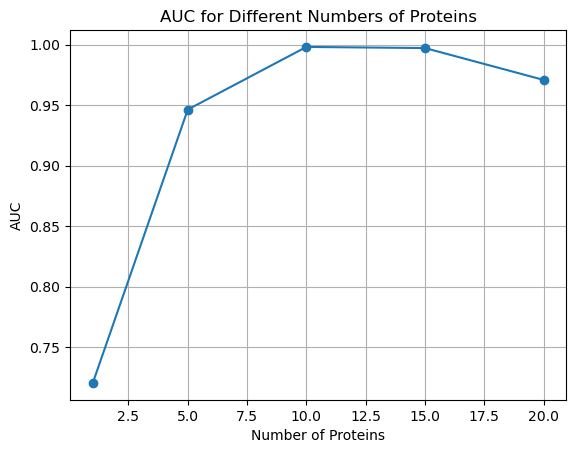

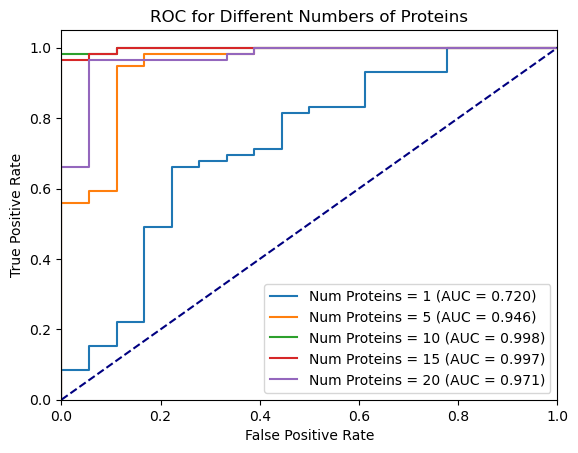

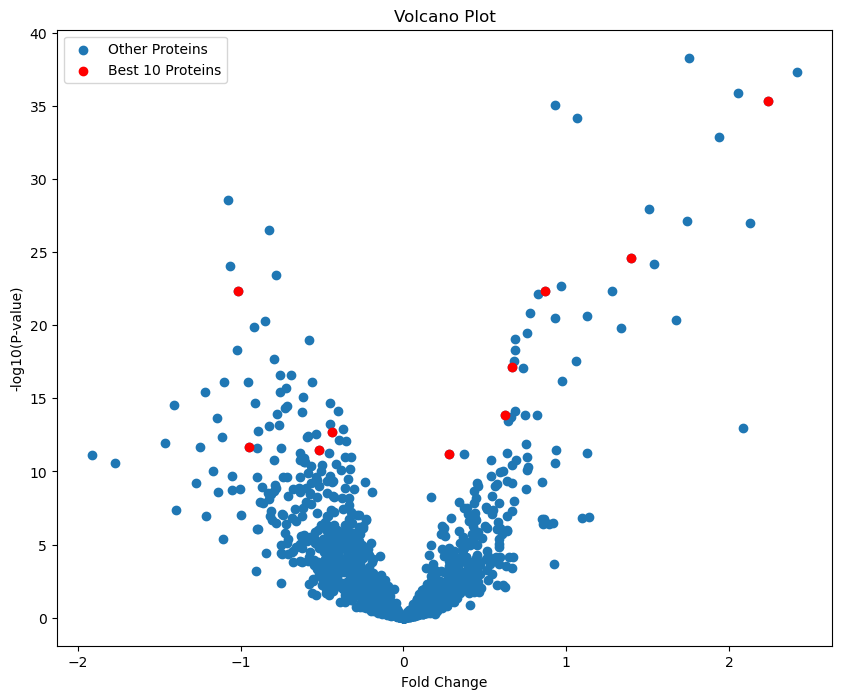

In [185]:
got_data = get_data()
df = got_data.load_dataset()

volcano = VolcanoPlot(df)
top_100, sig_up, sig_down = volcano.prepare_data()
volcano.plot()

best_proteins = set()
best_proteins.update(top_100)
# best_proteins.update(sig_up)
# best_proteins.update(sig_down)
best_proteins = list(best_proteins)

dataset_dic = got_data.split_data(best_proteins)

num_proteins = [1, 5, 10, 15, 20]
param_grid = {
    'C': np.logspace(-2, 2, 5),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

accuracy_values = []
auc_values = []
roc_curve_data = []

best_accuracy = 0
best_auc = 0
best_num = 0

lr = Logistic_Regression(dataset_dic)
lr.train()
lr.plot_all_proteins()

for num in num_proteins:
    lr.train()
    lr.LASSO(num)
    lr.hyperparam_search(param_grid)
    accuracy, auc, fpr_tpr = lr.evaluate()
    
    accuracy_values.append(accuracy)
    auc_values.append(auc)
    roc_curve_data.append(fpr_tpr)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_auc = auc
        best_num = num

lr.train()
X = lr.LASSO(best_num)
lr.plot_best_proteins(num)
    
# Plot accuracy values
plt.figure()
plt.plot(num_proteins, accuracy_values, marker='o')
plt.xlabel('Number of Proteins')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Numbers of Proteins')
plt.grid(True)
plt.show()

# Plot AUC values
plt.figure()
plt.plot(num_proteins, auc_values, marker='o')
plt.xlabel('Number of Proteins')
plt.ylabel('AUC')
plt.title('AUC for Different Numbers of Proteins')
plt.grid(True)
plt.show()

# Plot ROC curve
plt.figure()
for i, (fpr, tpr) in enumerate(roc_curve_data):
    plt.plot(fpr, tpr, label = f'Num Proteins = {num_proteins[i]} (AUC = {auc_values[i]:.3f})')
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Different Numbers of Proteins')
plt.legend(loc="lower right")
plt.show()

# Plot Volcano w/ Best Proteins
best_proteins = get_protein_names(dataset_dic['train']['X'], X)
volcano.plot_best_proteins(best_proteins)
